# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
import config
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 0

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

'cpu'

# Prepare data

## Dataset

In [5]:
ds = config.datasets[8]
ds

'Pendigits'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([10992, 16]), torch.Size([10992]), 10992, 16, 10)

## Pseudo-electrical Signal

In [7]:
X = X - torch.min(X, axis=0)[0]
X = X / (torch.max(X, axis=0)[0])
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.4700, 1.0000, 0.2700, 0.8100, 0.5700, 0.3700, 0.2600, 0.0000, 0.0000],
        [0.0000, 0.8900, 0.2700, 1.0000, 0.4200, 0.7500, 0.2900, 0.4500, 0.1500],
        [0.0000, 0.5700, 0.3100, 0.6800, 0.7200, 0.9000, 1.0000, 1.0000, 0.7600],
        [0.0000, 1.0000, 0.0700, 0.9200, 0.0500, 0.6800, 0.1900, 0.4500, 0.8600],
        [0.0000, 0.6700, 0.4900, 0.8300, 1.0000, 1.0000, 0.8100, 0.8000, 0.6000],
        [1.0000, 1.0000, 0.8800, 0.9900, 0.4900, 0.7400, 0.1700, 0.4700, 0.0000],
        [0.0000, 1.0000, 0.0300, 0.7200, 0.2600, 0.3500, 0.8500, 0.3500, 1.0000],
        [0.0000, 0.3900, 0.0200, 0.6200, 0.1100, 0.0500, 0.6300, 0.0000, 1.0000],
        [0.1300, 0.8900, 0.1200, 0.5000, 0.7200, 0.3800, 0.5600, 0.0000, 0.0400],
        [0.5700, 1.0000, 0.2200, 0.7200, 0.0000, 0.3100, 0.2500, 0.0000, 0.7500]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_test = min(2048, int(E*test_rate))
E_valid = min(2048, int(E*valid_rate))

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(6595, 2048, 2048)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [11]:
N_Hidden = 3
m = 0.3
T = 0.1
M_train = 50
K_train = 10
M_test = 20
K_test = 10

# Normal NN

## Define

In [12]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                        torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

NN.apply(weights_init)

celoss = torch.nn.CrossEntropyLoss()
NN.to(device)

Sequential(
  (0): Linear(in_features=16, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=10, bias=True)
  (3): Tanh()
)

## Training

In [13]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.29199 | Loss: 2.106968641
| Epoch:   500 | Accuracy: 0.64160 | Loss: 1.149085522
| Epoch:  1000 | Accuracy: 0.64355 | Loss: 1.142750621
| Epoch:  1500 | Accuracy: 0.63965 | Loss: 1.150266051
| Epoch:  2000 | Accuracy: 0.63721 | Loss: 1.146693230
| Epoch:  2500 | Accuracy: 0.64844 | Loss: 1.143072367
| Epoch:  3000 | Accuracy: 0.64404 | Loss: 1.141288400
| Epoch:  3500 | Accuracy: 0.64307 | Loss: 1.143313169
| Epoch:  4000 | Accuracy: 0.64307 | Loss: 1.146432757
| Epoch:  4500 | Accuracy: 0.64307 | Loss: 1.142185807
| Epoch:  5000 | Accuracy: 0.64111 | Loss: 1.149959326
Early stop.
Finished.


(4822, 1.134224534034729)

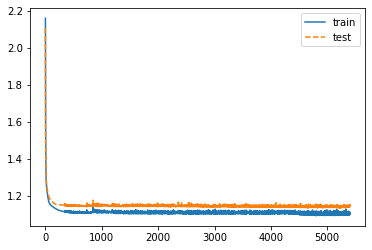

In [14]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [15]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.59863 | Loss: 1.234377742
| Epoch:   500 | Accuracy: 0.64453 | Loss: 1.137212873
| Epoch:  1000 | Accuracy: 0.64355 | Loss: 1.136791945
| Epoch:  1500 | Accuracy: 0.64307 | Loss: 1.136705160
| Epoch:  2000 | Accuracy: 0.64404 | Loss: 1.137127995
| Epoch:  2500 | Accuracy: 0.64111 | Loss: 1.136366725
| Epoch:  3000 | Accuracy: 0.64111 | Loss: 1.138890982
| Epoch:  3500 | Accuracy: 0.64111 | Loss: 1.136678576
| Epoch:  4000 | Accuracy: 0.64062 | Loss: 1.136329293
| Epoch:  4500 | Accuracy: 0.64160 | Loss: 1.136553407
| Epoch:  5000 | Accuracy: 0.64307 | Loss: 1.136389732
Early stop.
Finished.


(3020, 1.1339163780212402)

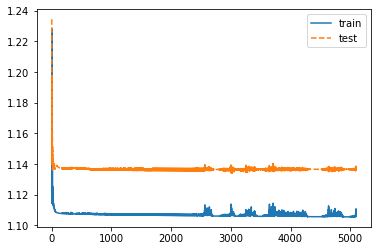

In [16]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [17]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.005)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.64307 | Loss: 1.136107445
| Epoch:   500 | Accuracy: 0.64209 | Loss: 1.136414886
| Epoch:  1000 | Accuracy: 0.64258 | Loss: 1.136373281
| Epoch:  1500 | Accuracy: 0.64062 | Loss: 1.136500001
| Epoch:  2000 | Accuracy: 0.64111 | Loss: 1.136421680
| Epoch:  2500 | Accuracy: 0.64111 | Loss: 1.136388779
| Epoch:  3000 | Accuracy: 0.64062 | Loss: 1.136438489
| Epoch:  3500 | Accuracy: 0.64160 | Loss: 1.136425734
| Epoch:  4000 | Accuracy: 0.64160 | Loss: 1.136521935
| Epoch:  4500 | Accuracy: 0.64160 | Loss: 1.136485457
| Epoch:  5000 | Accuracy: 0.64014 | Loss: 1.136403680
Early stop.
Finished.


(9, 1.1347285509109497)

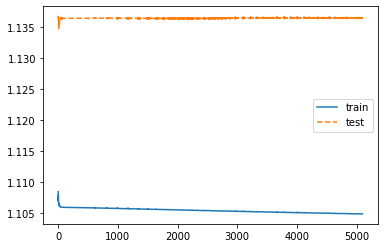

In [18]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## Save Model

In [19]:
with open(f'./result/{ds}_NN_{seed}.p', 'wb') as f:
    pickle.dump(NN, f)

## Evaluation

In [20]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.cpu().data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.cpu().numpy()) / y_valid.shape[0]
print(acc_valid)

0.6357421875


In [21]:
NN.to('cpu')

Sequential(
  (0): Linear(in_features=16, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=10, bias=True)
  (3): Tanh()
)

# Normal PNN

## Define

In [22]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [23]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.02)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=25000, cache=ds)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.09717 | Loss: 1.285888910 |
| Epoch:   500 | Accuracy: 0.45801 | Loss: 0.493423283 |
| Epoch:  1000 | Accuracy: 0.47168 | Loss: 0.490188241 |
| Epoch:  1500 | Accuracy: 0.47998 | Loss: 0.490274549 |
| Epoch:  2000 | Accuracy: 0.45898 | Loss: 0.490008771 |
| Epoch:  2500 | Accuracy: 0.45898 | Loss: 0.491257697 |
| Epoch:  3000 | Accuracy: 0.45801 | Loss: 0.489958882 |
| Epoch:  3500 | Accuracy: 0.45898 | Loss: 0.490773886 |
| Epoch:  4000 | Accuracy: 0.48242 | Loss: 0.489501864 |
| Epoch:  4500 | Accuracy: 0.47803 | Loss: 0.489206612 |
| Epoch:  5000 | Accuracy: 0.45850 | Loss: 0.490280300 |
| Epoch:  5500 | Accuracy: 0.47803 | Loss: 0.489470810 |
Early stop.
Finished.


(4954, 0.48874086141586304)

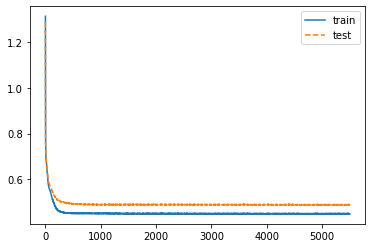

In [24]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [25]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.02)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=25000, cache=ds)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.46240 | Loss: 0.499176145 |
| Epoch:   500 | Accuracy: 0.46045 | Loss: 0.489039123 |
| Epoch:  1000 | Accuracy: 0.47852 | Loss: 0.489249766 |
| Epoch:  1500 | Accuracy: 0.46045 | Loss: 0.490054309 |
| Epoch:  2000 | Accuracy: 0.48389 | Loss: 0.490106910 |
| Epoch:  2500 | Accuracy: 0.48096 | Loss: 0.489973009 |
| Epoch:  3000 | Accuracy: 0.48047 | Loss: 0.490093887 |
| Epoch:  3500 | Accuracy: 0.48096 | Loss: 0.489379108 |
| Epoch:  4000 | Accuracy: 0.45752 | Loss: 0.489137381 |
| Epoch:  4500 | Accuracy: 0.45996 | Loss: 0.488890409 |
| Epoch:  5000 | Accuracy: 0.47803 | Loss: 0.489963353 |
Early stop.
Finished.


(4977, 0.4881243109703064)

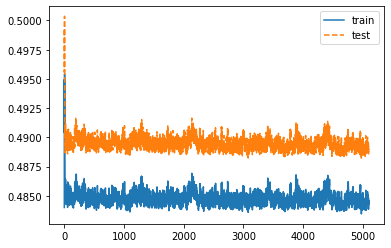

In [26]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [27]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.002)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=25000, cache=ds)

  0%|          | 0/25000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.45996 | Loss: 0.488854587 |
| Epoch:   500 | Accuracy: 0.47168 | Loss: 0.488028765 |
| Epoch:  1000 | Accuracy: 0.45752 | Loss: 0.487967610 |
| Epoch:  1500 | Accuracy: 0.45752 | Loss: 0.487955630 |
| Epoch:  2000 | Accuracy: 0.47217 | Loss: 0.488007456 |
| Epoch:  2500 | Accuracy: 0.47803 | Loss: 0.488005519 |
| Epoch:  3000 | Accuracy: 0.48047 | Loss: 0.488100141 |
| Epoch:  3500 | Accuracy: 0.48389 | Loss: 0.488169163 |
| Epoch:  4000 | Accuracy: 0.47852 | Loss: 0.488084495 |
| Epoch:  4500 | Accuracy: 0.47852 | Loss: 0.487982333 |
| Epoch:  5000 | Accuracy: 0.47852 | Loss: 0.487972498 |
Early stop.
Finished.


(4985, 0.48790982365608215)

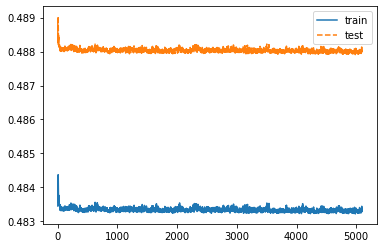

In [28]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## Save Model

In [29]:
with open(f'./result/{ds}_PNN_{seed}.p', 'wb') as f:
    pickle.dump(PNN, f)

In [30]:
PNN.to('cpu')

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

# Aging Aware PNN

In [12]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [13]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [14]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=150, cache=ds)

  0%|          | 0/150 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.09847 | Loss: 1.314536572 |
| Epoch:     7 | Accuracy: 0.19550 | Loss: 0.969936967 |
| Epoch:    14 | Accuracy: 0.19730 | Loss: 0.998467565 |
| Epoch:    21 | Accuracy: 0.24724 | Loss: 0.905308247 |
| Epoch:    28 | Accuracy: 0.26567 | Loss: 0.940915525 |
| Epoch:    35 | Accuracy: 0.31863 | Loss: 0.879155278 |
| Epoch:    42 | Accuracy: 0.34483 | Loss: 0.863723755 |
| Epoch:    49 | Accuracy: 0.41271 | Loss: 0.772809803 |
| Epoch:    56 | Accuracy: 0.42915 | Loss: 0.766672730 |
| Epoch:    63 | Accuracy: 0.44646 | Loss: 0.748046100 |
| Epoch:    70 | Accuracy: 0.44256 | Loss: 0.773437798 |
| Epoch:    77 | Accuracy: 0.42189 | Loss: 0.807343721 |
| Epoch:    84 | Accuracy: 0.43824 | Loss: 0.795660019 |
| Epoch:    91 | Accuracy: 0.44613 | Loss: 0.772171795 |
| Epoch:    98 | Accuracy: 0.45004 | Loss: 0.765692055 |
| Epoch:   105 | Accuracy: 0.45450 | Loss: 0.749626517 |
| Epoch:   112 | Accuracy: 0.51562 | Loss: 0.722896874 |
| Epoch:   119 | Accuracy: 0.55

(135, 0.6220396161079407)

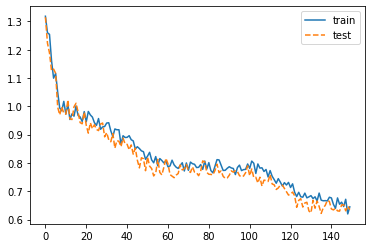

In [15]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [16]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.57030 | Loss: 0.635289371 |
| Epoch:    12 | Accuracy: 0.57429 | Loss: 0.644272447 |
| Epoch:    24 | Accuracy: 0.57272 | Loss: 0.637918532 |
| Epoch:    36 | Accuracy: 0.57995 | Loss: 0.630374610 |
| Epoch:    48 | Accuracy: 0.56972 | Loss: 0.642033219 |
| Epoch:    60 | Accuracy: 0.56557 | Loss: 0.644615233 |
| Epoch:    72 | Accuracy: 0.57349 | Loss: 0.653560817 |
| Epoch:    84 | Accuracy: 0.56845 | Loss: 0.643557429 |
| Epoch:    96 | Accuracy: 0.58771 | Loss: 0.621717393 |
| Epoch:   108 | Accuracy: 0.56476 | Loss: 0.654738784 |
| Epoch:   120 | Accuracy: 0.55510 | Loss: 0.639820695 |
| Epoch:   132 | Accuracy: 0.56641 | Loss: 0.650432229 |
| Epoch:   144 | Accuracy: 0.58672 | Loss: 0.619448960 |
| Epoch:   156 | Accuracy: 0.57080 | Loss: 0.662978053 |
| Epoch:   168 | Accuracy: 0.57035 | Loss: 0.630398273 |
| Epoch:   180 | Accuracy: 0.56770 | Loss: 0.643987179 |
| Epoch:   192 | Accuracy: 0.57087 | Loss: 0.646285474 |
| Epoch:   204 | Accuracy: 0.59

(88, 0.6016548275947571)

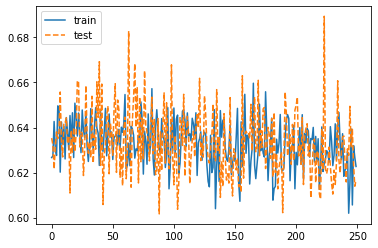

In [17]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [18]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.57619 | Loss: 0.645039976 |
| Epoch:    12 | Accuracy: 0.57161 | Loss: 0.624958396 |
| Epoch:    24 | Accuracy: 0.57795 | Loss: 0.628694355 |
| Epoch:    36 | Accuracy: 0.56152 | Loss: 0.665233970 |
| Epoch:    48 | Accuracy: 0.56202 | Loss: 0.657961667 |
| Epoch:    60 | Accuracy: 0.57004 | Loss: 0.639231265 |
| Epoch:    72 | Accuracy: 0.57210 | Loss: 0.633881748 |
| Epoch:    84 | Accuracy: 0.57424 | Loss: 0.635161400 |
| Epoch:    96 | Accuracy: 0.54987 | Loss: 0.679967701 |
| Epoch:   108 | Accuracy: 0.57939 | Loss: 0.633888721 |
| Epoch:   120 | Accuracy: 0.56815 | Loss: 0.634072244 |
| Epoch:   132 | Accuracy: 0.57512 | Loss: 0.624881387 |
| Epoch:   144 | Accuracy: 0.56972 | Loss: 0.627275825 |
| Epoch:   156 | Accuracy: 0.58474 | Loss: 0.626327574 |
| Epoch:   168 | Accuracy: 0.56509 | Loss: 0.639849484 |
| Epoch:   180 | Accuracy: 0.58058 | Loss: 0.623205841 |
| Epoch:   192 | Accuracy: 0.57445 | Loss: 0.638708711 |
| Epoch:   204 | Accuracy: 0.58

(49, 0.596794068813324)

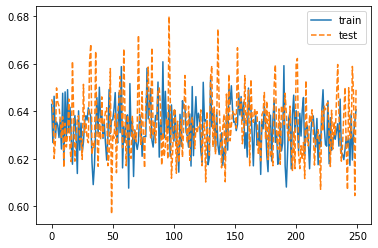

In [19]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [20]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)